# Introduction to PySpark

Inspired by https://app.datacamp.com/learn/courses/introduction-to-pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, IntegerType, StringType
import matplotlib.pyplot as plt

# spark.stop()
spark = SparkSession.builder.getOrCreate()
print(spark)

In [2]:
spark.sparkContext

<SparkContext master=local[*] appName=pyspark-shell>

Think of the `SparkContext` as a connection to a cluster and the `SparkSession` as the interface with that connection.

In [3]:
schema = StructType() \
      .add('year', IntegerType(), True) \
      .add('month', IntegerType(), True) \
      .add('day', IntegerType(), True) \
      .add('dep_time', IntegerType(), True) \
      .add('dep_delay', IntegerType(), True) \
      .add('arr_time', IntegerType(), True) \
      .add('arr_delay', IntegerType(), True) \
      .add('carrier', StringType(), True) \
      .add('tailnum', StringType(), True) \
      .add('flight', StringType(), True) \
      .add('origin', StringType(), True) \
      .add('dest', StringType(), True) \
      .add('air_time', IntegerType(), True) \
      .add('distance', IntegerType(), True) \
      .add('hour', IntegerType(), True) \
      .add('minute', IntegerType(), True) \

flights = spark.read.options(header='True') \
                    .schema(schema) \
                    .csv('data//flights_small.csv')

In [4]:
type(flights)

pyspark.sql.dataframe.DataFrame

In [5]:
flights.show(5)

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
+----+-----+---+--------+---------+-----

In [6]:
flights.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: integer (nullable = true)
 |-- dep_delay: integer (nullable = true)
 |-- arr_time: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [7]:
spark.catalog.listTables()

[]

`flights` is stored locally, not in the `SparkSession` catalog. This means that we can use all the Spark DataFrame methods on it, but we can't access the data in other contexts.

For example, a SQL query (using the `.sql()` method) that references your DataFrame will throw an error. To access the data in this way, we have to save it as a temporary table.

In [8]:
flights.createOrReplaceTempView('flights')

In [9]:
spark.catalog.listTables()

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

We can now run a query, make the dataset smaller and convert it to a pandas data frame (eg for EDA, plotting).

`--sql` enables SQL syntax highlighting in VSCode.
https://github.com/ptweir/python-string-sql

In [10]:
q = """--sql
SELECT origin, dest, COUNT(*) as N 
FROM flights 
GROUP BY origin, dest
;
"""
flight_counts = spark.sql(q)

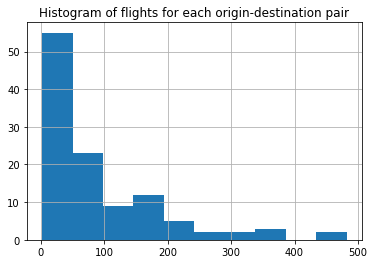

In [11]:
pd_counts = flight_counts.toPandas()
pd_counts.hist('N')
plt.title("Histogram of flights for each origin-destination pair")
plt.show()

## SQL-equivalent PySpark DataFrames methods

In [12]:
q = """
--sql
SELECT origin, dest, air_time/60 AS duration_hrs
FROM flights
;
"""
spark.sql(q).show(5)

+------+----+------------------+
|origin|dest|      duration_hrs|
+------+----+------------------+
|   SEA| LAX|               2.2|
|   SEA| HNL|               6.0|
|   SEA| SFO|              1.85|
|   PDX| SJC|1.3833333333333333|
|   SEA| BUR|2.1166666666666667|
+------+----+------------------+
only showing top 5 rows



The same can be achieved with `.select` and `.alias`

In [13]:
flights \
    .select('origin', 'dest', (flights.air_time/60).alias('duration_hrs')) \
    .show(5)

+------+----+------------------+
|origin|dest|      duration_hrs|
+------+----+------------------+
|   SEA| LAX|               2.2|
|   SEA| HNL|               6.0|
|   SEA| SFO|              1.85|
|   PDX| SJC|1.3833333333333333|
|   SEA| BUR|2.1166666666666667|
+------+----+------------------+
only showing top 5 rows



The same can be achieved with `.filter`

In [14]:
q = """
--sql
SELECT origin, dest, distance
FROM flights
WHERE distance > 1000 AND distance < 2000
;
"""
spark.sql(q).show(5)

+------+----+--------+
|origin|dest|distance|
+------+----+--------+
|   SEA| SAN|    1050|
|   SEA| ORD|    1721|
|   SEA| PHX|    1107|
|   SEA| ANC|    1448|
|   SEA| MDW|    1733|
+------+----+--------+
only showing top 5 rows



In [15]:
flights \
    .filter(flights.distance > 1000) \
    .filter(flights.distance < 2000) \
    .select('origin', 'dest', 'distance') \
    .show(5)

+------+----+--------+
|origin|dest|distance|
+------+----+--------+
|   SEA| SAN|    1050|
|   SEA| ORD|    1721|
|   SEA| PHX|    1107|
|   SEA| ANC|    1448|
|   SEA| MDW|    1733|
+------+----+--------+
only showing top 5 rows



In [16]:
q = """
--sql
SELECT MIN(distance) AS min_dist_from_PDX
FROM flights
WHERE origin = "PDX"
;
"""
spark.sql(q).show(5)

+-----------------+
|min_dist_from_PDX|
+-----------------+
|              106|
+-----------------+



The same can be achieved with `.min`, `.max`, `.count`, `.avg` etc but these methods are only available for a GroupedData object, so we need to convert it with `.groupBy()` even if we don't actually use it.

In [17]:
flights \
    .filter(flights.origin=='PDX') \
    .groupBy() \
    .min('distance') \
    .show(5)

+-------------+
|min(distance)|
+-------------+
|          106|
+-------------+



The disadvantage is that we cannot alias the new column. The `.agg` method accepts sql functions like `min()`, `max()`, `count()`, `avg()` and they can be aliased.

In [18]:
from pyspark.sql.functions import min

flights \
    .filter(flights.origin=='PDX') \
    .groupBy() \
    .agg(min('distance').alias('min_dist_from_PDX')) \
    .show(5)

+-----------------+
|min_dist_from_PDX|
+-----------------+
|              106|
+-----------------+



In [19]:
from pyspark.sql.functions import avg, stddev

flights \
    .groupBy('dest') \
    .agg(avg('dep_delay').alias('avg_dep_delay'), stddev('dep_delay').alias('sd_dep_delay')) \
    .orderBy('avg_dep_delay', ascending=False) \
    .show(5)

+----+------------------+-----------------+
|dest|     avg_dep_delay|     sd_dep_delay|
+----+------------------+-----------------+
| CLE|              31.5|23.33452377915607|
| BWI|              16.0|32.11343530786962|
| SFO|13.309370988446727| 34.1416307929602|
| EWR|12.753521126760564|34.52046091170115|
| MCO|11.096774193548388|40.20394245900907|
+----+------------------+-----------------+
only showing top 5 rows



Let's improve the table above by adding a column with the actual names of the airports.

In [20]:
from pyspark.sql.types import DoubleType

schema = StructType() \
      .add('faa', StringType(), True) \
      .add('name', StringType(), True) \
      .add('lat', DoubleType(), True) \
      .add('lon', DoubleType(), True) \
      .add('alt', IntegerType(), True) \
      .add('tz', IntegerType(), True) \
      .add('dst', StringType(), True) \

airports = spark.read.options(header='True') \
                     .schema(schema) \
                     .csv('data//airports.csv')

airports.createOrReplaceTempView('airports')

In SQL we would do this.

In [21]:
q = """
--sql
SELECT dest AS dest_code, name as dest_name, avg_dep_delay, sd_dep_delay
FROM (
    SELECT dest, AVG(dep_delay) AS avg_dep_delay, STDDEV(dep_delay) AS sd_dep_delay
    FROM flights
    GROUP BY dest
)
JOIN airports ON dest = faa
ORDER BY avg_dep_delay DESC
;
"""

spark.sql(q).show(5, truncate=False)

+---------+-------------------------+------------------+-----------------+
|dest_code|dest_name                |avg_dep_delay     |sd_dep_delay     |
+---------+-------------------------+------------------+-----------------+
|CLE      |Cleveland Hopkins Intl   |31.5              |23.33452377915607|
|BWI      |Baltimore Washington Intl|16.0              |32.11343530786962|
|SFO      |San Francisco Intl       |13.309370988446727|34.1416307929602 |
|EWR      |Newark Liberty Intl      |12.753521126760564|34.52046091170115|
|MCO      |Orlando Intl             |11.096774193548388|40.20394245900907|
+---------+-------------------------+------------------+-----------------+
only showing top 5 rows



With PySpark API the same can be achieved with this.

In [22]:
flights \
    .groupBy('dest') \
    .agg(avg('dep_delay').alias('avg_dep_delay'), stddev('dep_delay').alias('sd_dep_delay')) \
    .orderBy('avg_dep_delay', ascending=False) \
    .join(airports, flights.dest == airports.faa, 'left') \
    .select((flights.dest).alias('dest_code'), (airports.name).alias('dest_name'), 'avg_dep_delay', 'sd_dep_delay') \
    .show(5, truncate=False)

+---------+-------------------------+------------------+-----------------+
|dest_code|dest_name                |avg_dep_delay     |sd_dep_delay     |
+---------+-------------------------+------------------+-----------------+
|CLE      |Cleveland Hopkins Intl   |31.5              |23.33452377915607|
|BWI      |Baltimore Washington Intl|16.0              |32.11343530786962|
|SFO      |San Francisco Intl       |13.309370988446727|34.1416307929602 |
|EWR      |Newark Liberty Intl      |12.753521126760564|34.52046091170115|
|MCO      |Orlando Intl             |11.096774193548388|40.20394245900907|
+---------+-------------------------+------------------+-----------------+
only showing top 5 rows



## PySpark ML

In [23]:
schema = StructType() \
      .add('tailnum', StringType(), True) \
      .add('year', IntegerType(), True) \
      .add('type', StringType(), True) \
      .add('manufacturer', StringType(), True) \
      .add('model', StringType(), True) \
      .add('engines', IntegerType(), True) \
      .add('seats', IntegerType(), True) \
      .add('speed', IntegerType(), True) \
      .add('engine', StringType(), True) \

planes = spark.read.options(header='True') \
                    .schema(schema) \
                    .csv('data//planes.csv')

planes.createOrReplaceTempView('planes')

In [24]:
planes = planes.withColumnRenamed('year', 'plane_year')
flights_planes = flights.join(planes, on='tailnum', how='left')
flights_planes.createOrReplaceTempView('flights_planes')

In [25]:
q = """
--sql
SELECT month,
       air_time,
       carrier, 
       dest, 
       year - plane_year AS plane_age,
       CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END AS label
FROM flights_planes
;
"""

model_data = spark.sql(q)
model_data.createOrReplaceTempView('model_data')

In [26]:
print((model_data.count(), len(model_data.columns)))

(10000, 6)


In [27]:
q = """
--sql
SELECT COUNT(*) - COUNT(month) AS month,
       COUNT(*) - COUNT(air_time) AS air_time,
       COUNT(*) - COUNT(carrier) AS carrier,
       COUNT(*) - COUNT(dest) AS dest,
       COUNT(*) - COUNT(plane_age) AS plane_age,
       COUNT(*) - COUNT(label) AS label
FROM (
    SELECT month,
           air_time,
           carrier, 
           dest, 
           year - plane_year AS plane_age,
           CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END AS label
    FROM flights_planes
)
;
"""
spark.sql(q).show()

+-----+--------+-------+----+---------+-----+
|month|air_time|carrier|dest|plane_age|label|
+-----+--------+-------+----+---------+-----+
|    0|      75|      0|   0|      646|    0|
+-----+--------+-------+----+---------+-----+



The same can be achieved with this.

In [28]:
from pyspark.sql.functions import isnan, when, count, col

model_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in model_data.columns]).show()

+-----+--------+-------+----+---------+-----+
|month|air_time|carrier|dest|plane_age|label|
+-----+--------+-------+----+---------+-----+
|    0|      75|      0|   0|      646|    0|
+-----+--------+-------+----+---------+-----+



In [29]:
q = """
--sql
SELECT COUNT(*) AS row_count_one_or_more_null
FROM (
    SELECT month,
           air_time,
           carrier, 
           dest, 
           year - plane_year AS plane_age,
           CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END AS label
    FROM flights_planes
)
WHERE month IS NULL OR air_time IS NULL OR carrier IS NULL OR dest IS NULL OR plane_age IS NULL OR label IS NULL
;
"""
spark.sql(q).show()

+--------------------------+
|row_count_one_or_more_null|
+--------------------------+
|                       697|
+--------------------------+



The same can be achieved with this.

In [30]:
model_data.filter(" OR ".join([c + ' IS NULL' for c in model_data.columns])).count()

697

In [31]:
q = """
--sql
SELECT *
FROM (
    SELECT month,
           air_time,
           carrier, 
           dest, 
           year - plane_year AS plane_age,
           CASE WHEN arr_delay > 0 THEN 1 ELSE 0 END AS label
    FROM flights_planes
)
WHERE month IS NOT NULL AND air_time IS NOT NULL AND carrier IS NOT NULL AND dest IS NOT NULL AND plane_age IS NOT NULL AND label IS NOT NULL
;
"""
model_data_nona = spark.sql(q)
print((model_data_nona.count(), len(model_data_nona.columns)))

(9303, 6)


In [32]:
model_data_nona.createOrReplaceTempView('model_data_nona')

The same can be achieved with this.

In [33]:
model_data_nona = model_data.dropna()
print((model_data_nona.count(), len(model_data_nona.columns)))

(9303, 6)


In [34]:
q = """
--sql
SELECT 1-AVG(label) AS prop_no_delay, AVG(label) AS prop_delay
FROM model_data_nona
;
"""
spark.sql(q).show()

+------------------+-------------------+
|     prop_no_delay|         prop_delay|
+------------------+-------------------+
|0.6242072449747393|0.37579275502526066|
+------------------+-------------------+



The same can be achieved with this.

In [35]:
model_data_nona.agg((1-avg('label')).alias('prop_no_delay'), avg('label').alias('prop_delay')).show()

+------------------+-------------------+
|     prop_no_delay|         prop_delay|
+------------------+-------------------+
|0.6242072449747393|0.37579275502526066|
+------------------+-------------------+



1. Build a preprocessing pipeline to one-hot encode the categorical features and merge them back with the numerical features
2. Split the processed data into train and test
3. Build hyperparameter grid for the regularization parameter and the L1/L2 ratio (Lasso or Ridge) for a logistic regression model
4. Train the model using 5-fold cross validation and evaluate using ROC AUC
5. Evaluate the best model on test set

In [36]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

carr_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_index')
carr_encoder = OneHotEncoder(inputCol='carrier_index', outputCol='carrier_fact')

dest_indexer = StringIndexer(inputCol='dest', outputCol='dest_index')
dest_encoder = OneHotEncoder(inputCol='dest_index', outputCol='dest_fact')

vec_assembler = VectorAssembler(inputCols=['month', 'air_time', 'carrier_fact', 'dest_fact', 'plane_age'], outputCol='features')

flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, carr_indexer, carr_encoder, vec_assembler])

In [37]:
piped_data = flights_pipe.fit(model_data_nona).transform(model_data_nona)

In [38]:
piped_data.show(5)

+-----+--------+-------+----+---------+-----+----------+---------------+-------------+--------------+--------------------+
|month|air_time|carrier|dest|plane_age|label|dest_index|      dest_fact|carrier_index|  carrier_fact|            features|
+-----+--------+-------+----+---------+-----+----------+---------------+-------------+--------------+--------------------+
|   12|     132|     VX| LAX|        3|    0|       1.0| (68,[1],[1.0])|          7.0|(10,[7],[1.0])|(81,[0,1,9,13,80]...|
|    1|     360|     AS| HNL|        8|    1|      19.0|(68,[19],[1.0])|          0.0|(10,[0],[1.0])|(81,[0,1,2,31,80]...|
|    3|     111|     VX| SFO|        3|    1|       0.0| (68,[0],[1.0])|          7.0|(10,[7],[1.0])|(81,[0,1,9,12,80]...|
|    4|      83|     WN| SJC|       22|    1|       7.0| (68,[7],[1.0])|          1.0|(10,[1],[1.0])|(81,[0,1,3,19,80]...|
|    3|     127|     AS| BUR|       15|    1|      22.0|(68,[22],[1.0])|          0.0|(10,[0],[1.0])|(81,[0,1,2,34,80]...|
+-----+--------+

In [39]:
training, test = piped_data.randomSplit([.6,.4])

In [40]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

In [41]:
import pyspark.ml.evaluation as evals
import pyspark.ml.tuning as tune
import numpy as np

evaluator = evals.BinaryClassificationEvaluator(metricName='areaUnderROC')

grid = tune.ParamGridBuilder() \
    .addGrid(lr.regParam, np.arange(0, .1, .01)) \
    .addGrid(lr.elasticNetParam, [0,1]) \
    .build()

In [42]:
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator,
               numFolds=5
               )

In [43]:
best_lr = lr.fit(training)
print(best_lr)

LogisticRegressionModel: uid=LogisticRegression_267b260b7440, numClasses=2, numFeatures=81


In [44]:
test_results = best_lr.transform(test)
print(evaluator.evaluate(test_results))

0.6962808496360657
